In [17]:
# Import dependencies
import pandas as pd
pd.set_option('max_colwidth', 400)
import matplotlib.pyplot as plt
# import hvplot.pandas
# import numpy as np
import csv
import json
from pymongo import MongoClient
from pprint import pprint
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# import seaborn as sns
import ipywidgets as widgets
# from ipywidgets import interact
# from IPython.display import clear_output
# from IPython.display import display


In [18]:
# read the origianl dataset extracted from data.world
original_df = pd.read_excel('Resources/ABBREV.xlsx')

In [19]:
#  Transform data for analyses
# Define a function to categorise food items based on their descriptions
def categorise_food(desc):
    desc_upper = desc.upper()
    if any(fruit in desc_upper for fruit in ['APPLE', 'BANANA', 'ORANGE', 'BERRY', 'FRUIT']):
        return 'Fruits'
    elif any(veggie in desc_upper for veggie in ['SPINACH', 'BROCCOLI', 'CARROT', 'LETTUCE', 'VEGETABLE']):
        return 'Vegetables'
    elif any(meat in desc_upper for meat in ['CHICKEN', 'BEEF', 'PORK', 'LAMB', 'MEAT']):
        return 'Meats'
    elif 'CHEESE' in desc_upper or 'MILK' in desc_upper or 'YOGURT' in desc_upper or 'DAIRY' in desc_upper:
        return 'Dairy'
    elif any(grain in desc_upper for grain in ['RICE', 'WHEAT', 'OATS', 'GRAIN', 'BREAD']):
        return 'Grains'
    elif any(nut in desc_upper for nut in ['ALMOND', 'WALNUT', 'SEED', 'NUT']):
        return 'Nuts & Seeds'
    elif any(seafood in desc_upper for seafood in ['FISH', 'SALMON', 'TUNA', 'SEAFOOD']):
        return 'Seafood'
    else:
        return 'Other'
    
# Apply the categorisation function to the 'Shrt_Desc' column to create the 'Category' column
original_df['Category'] = original_df['Shrt_Desc'].apply(categorise_food)

In [20]:
# select 100 samples for each category for analyses and visualisations
sampled_df = original_df.groupby('Category').apply(lambda x: x.head(100)).reset_index(drop=True)

sampled_df.head()
sampled_df.columns

Index(['NDB_No', 'Shrt_Desc', 'Water_(g)', 'Energ_Kcal', 'Protein_(g)',
       'Lipid_Tot_(g)', 'Ash_(g)', 'Carbohydrt_(g)', 'Fiber_TD_(g)',
       'Sugar_Tot_(g)', 'Calcium_(mg)', 'Iron_(mg)', 'Magnesium_(mg)',
       'Phosphorus_(mg)', 'Potassium_(mg)', 'Sodium_(mg)', 'Zinc_(mg)',
       'Copper_mg)', 'Manganese_(mg)', 'Selenium_(µg)', 'Vit_C_(mg)',
       'Thiamin_(mg)', 'Riboflavin_(mg)', 'Niacin_(mg)', 'Panto_Acid_mg)',
       'Vit_B6_(mg)', 'Folate_Tot_(µg)', 'Folic_Acid_(µg)', 'Food_Folate_(µg)',
       'Folate_DFE_(µg)', 'Choline_Tot_ (mg)', 'Vit_B12_(µg)', 'Vit_A_IU',
       'Vit_A_RAE', 'Retinol_(µg)', 'Alpha_Carot_(µg)', 'Beta_Carot_(µg)',
       'Beta_Crypt_(µg)', 'Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_E_(mg)',
       'Vit_D_µg', 'Vit_D_IU', 'Vit_K_(µg)', 'FA_Sat_(g)', 'FA_Mono_(g)',
       'FA_Poly_(g)', 'Cholestrl_(mg)', 'GmWt_1', 'GmWt_Desc1', 'GmWt_2',
       'GmWt_Desc2', 'Refuse_Pct', 'Category'],
      dtype='object')

In [21]:
# Only keep the columns most commonly listed in the food labels
reduced_columns_df = sampled_df[['Shrt_Desc','Energ_Kcal','Protein_(g)', 'Lipid_Tot_(g)', 'FA_Sat_(g)', 
                           'Carbohydrt_(g)','Sugar_Tot_(g)',\
                           'Fiber_TD_(g)','Sodium_(mg)','Category']]
# Rename the columnns; note: all in g but sodium which is in mg
food_label_df = reduced_columns_df.rename(columns={"Shrt_Desc":"name",
                                    "Energ_Kcal":"energy",
                                    "Protein_(g)": "protein",
                                    "Lipid_Tot_(g)": "fat_total",
                                    "FA_Sat_(g)":"satuated_fat",
                                    "Carbohydrt_(g)":"carbonhydrate",
                                    "Sugar_Tot_(g)":"sugar",
                                    "Fiber_TD_(g)":"dietary_fiber",
                                    "Sodium_(mg)":"sodium",
                                    "Category": "category"                                       
                                 })


In [22]:
# Drop the category "Other" to keep the clear categories in the final sample analyses
food_label_final_df = food_label_df.loc[food_label_df["category"] !="Other", :]

In [23]:
# Export both the original and final sample DataFrame for visualisations as CSV files. 
original_df.to_csv("Resources/original.csv", index=False)
food_label_final_df.to_csv("Resources/food_label_final.csv", index=False)

In [24]:
# Convert the csv files to json files
# Open the CSV file 
with open('Resources/original.csv', 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)

    data1 = []
    for row in csv_reader:
        data1.append(row)

# Write the data to a JSON file
with open('Resources/original.json', 'w') as json_file:
    json.dump(data1, json_file, indent=4)

with open('Resources/food_label_final.csv', 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)

    data2 = []
    for row in csv_reader:
        data2.append(row)

# Write the data to a JSON file
with open('Resources/food_label_final.json', 'w') as json_file:
    json.dump(data2, json_file, indent=4)

In [25]:
# import both the original and transformed json data files to pymongo database to store
#'mongoimport --type json -d food -c original --drop --jsonArray original.json'
#'mongoimport --type json -d food -c food_label_final --drop --jsonArray food_label_final.json'
# Create an instance of MongoClient
mongo = MongoClient(port=27017)

In [26]:
# Assign the nutrients database to a variable name
db = mongo['food']

In [27]:
# Review the collections in the database
print(db.list_collection_names())

['food_label_final', 'nutrients', 'original']


In [28]:
# Review an object in the nutrients collection
pprint(db.food_label_final.find_one())

{'_id': ObjectId('6619225e6cd7518d256da7a4'),
 'carbonhydrate': '2.72',
 'category': 'Dairy',
 'dietary_fiber': '0.0',
 'energy': '72',
 'fat_total': '1.02',
 'name': 'CHEESE,COTTAGE,LOWFAT,1% MILKFAT',
 'protein': '12.39',
 'satuated_fat': '0.645',
 'sodium': '406.0',
 'sugar': '2.72'}


In [29]:
# Calculate the average of each nutrient for each category
mean_by_category_df = food_label_final_df.groupby(['category']).mean().reset_index(drop=False)
mean_by_category_df

,category,energy,protein,fat_total,satuated_fat,carbonhydrate,sugar,dietary_fiber,sodium
0,Dairy,233.11,15.6131,14.8385,9.251620,9.3034,8.208642,0.031000,521.69
1,Fruits,129.46,2.8806,1.5924,0.516333,26.7713,14.256047,1.620213,73.53
2,Grains,274.32,7.5450,5.4924,1.054273,52.1865,8.051183,5.426531,216.00
3,Meats,225.34,20.8628,14.2603,4.467636,2.0837,0.115493,0.062637,106.68
4,Nuts & Seeds,343.55,6.1558,20.7423,5.619840,37.0574,18.529565,4.914286,181.04
5,Seafood,178.51,18.9776,10.5959,3.230204,0.6635,0.128542,0.023469,264.06
6,Vegetables,81.84,3.5881,2.6656,1.343771,11.7757,2.584353,2.473404,176.15


In [30]:
different_disc = food_label_final_df.groupby(['category']).mean()
fig = make_subplots(
    rows=2, cols=3,
    specs=[[{"type": "domain"},{"type": "domain"},{"type": "domain"}],
           [{"type": "domain"},{"type": "domain"},{"type": "domain"}]])

In [31]:

fig.add_trace(go.Pie(values=different_disc['energy'], 
                     title='calories', labels=different_disc.index, marker=dict(colors=['#100b','#f00560'], 
                    line=dict(color='#FFFFFF', width=2.5))),row=1, col=1)
fig.add_trace(go.Pie(values=different_disc['protein'], 
                     title='protein', labels=different_disc.index, marker=dict(colors=['#100b','#f00560'], 
                    line=dict(color='#FFFFFF', width=2.5))),row=1, col=2)
fig.add_trace(go.Pie(values=different_disc['satuated_fat'], 
                     title='sat.fat', labels=different_disc.index, marker=dict(colors=['#100b','#f00560'], 
                    line=dict(color='#FFFFFF', width=2.5))),row=1, col=3)
fig.add_trace(go.Pie(values=different_disc['carbonhydrate'], 
                     title='carbs', labels=different_disc.index, marker=dict(colors=['#100b','#f00560'], 
                    line=dict(color='#FFFFFF', width=2.5))),row=2, col=1)
fig.add_trace(go.Pie(values=different_disc['sugar'], 
                     title='sugar', labels=different_disc.index, marker=dict(colors=['#100b','#f00560'], 
                    line=dict(color='#FFFFFF', width=2.5))),row=2, col=2)
fig.add_trace(go.Pie(values=different_disc['dietary_fiber'], 
                     title='fiber', labels=different_disc.index, marker=dict(colors=['#100b','#f00560'], 
                    line=dict(color='#FFFFFF', width=2.5))),row=2, col=3)

fig.update_layout(title_text="Category wise distribution of all metrics", height=700, width=900)
fig.show()



Dropdown(description='Category 1:', options=('Dairy', 'Fruits', 'Grains', 'Meats', 'Nuts & Seeds', 'Seafood', …

Dropdown(description='Category 2:', options=('Dairy', 'Fruits', 'Grains', 'Meats', 'Nuts & Seeds', 'Seafood', …

Button(description='Compare Categories', style=ButtonStyle())

Output()

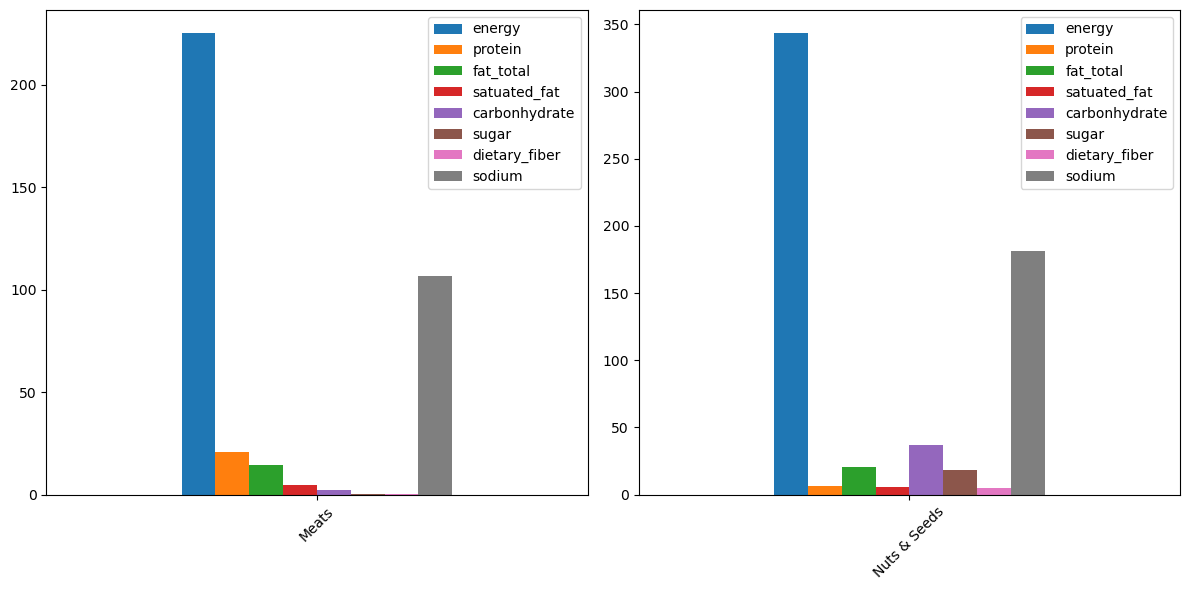

In [32]:
# Get the categories from the 'category' columns for dropdown menus
# categories = mean_by_category_df['category']
categories = mean_by_category_df['category'].unique()

# Create dropdown widgets for category selection
dropdown1 = widgets.Dropdown(options=categories, description='Category 1:')
dropdown2 = widgets.Dropdown(options=categories, description='Category 2:')

# Create a button widget for triggering the comparison
button = widgets.Button(description='Compare Categories')
# # Create an output widget for displaying the comparison results
output = widgets.Output()

# Define a function to compare the selected categories
def compare_categories(b):
    category1 = dropdown1.value
    category2 = dropdown2.value

    # Filter the DataFrame for the selected categories
    category1_data = mean_by_category_df[mean_by_category_df['category'] == category1]
    category2_data = mean_by_category_df[mean_by_category_df['category'] == category2]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    category1_data.plot(kind="bar", ax=ax1)
    ax1.set_xticklabels(category1_data["category"], rotation=45)

    # Plot the second category data
    category2_data.plot(kind="bar", ax=ax2)
    ax2.set_xticklabels(category2_data["category"], rotation=45)

    plt.tight_layout()
    plt.show()

# Link the button to to the function
button.on_click(compare_categories)

# # Display the widgets
display(dropdown1, dropdown2, button, output)